In [9]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using BAT
using Distributions 
using IntervalSets

using HCubature
using JLD
using CPUTime

using Plots
using Colors
using ColorSchemes
using LaTeXStrings

pyplot(size=(750,500))
line_colors = ColorSchemes.tab20b;

In [53]:
# Normal Distribtion: 

fun(x; μ=0, σ=1) = prod(pdf.(Normal(μ, σ), x))

N = 30
min_v = -10
max_v = 10
lgV = N*log(max_v-min_v);

# Estimated parameters of one run: 

# MCMC
# nchains = 5
# nsamples = 2*10^5
# max_time = 100
# max_nsteps = 10 * nsamples
#time for 30D -> 30 sec

# AHMI: 

# 30D - 256.263845 seconds Set: (1000, 1.5, 0.1, true, 16, true,)
# 30D - 371.146954 seconds for maximal srttings 


In [59]:
algorithm = MetropolisHastings()

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.5,
    c = 0.001..0.9
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 8..128,
    max_nsamples_init = 250,
    max_nsteps_init = 250,
    max_time_init = 180
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 1000,
    max_nsteps_per_cycle = 10000,
    max_time_per_cycle = 250,
    max_ncycles = 100
)

HMI_Manual_Settings = BAT.HMISettings(BAT.cholesky_partial_whitening!, 
        1000, 
        1.5, 
        0.1, 
        true, 
        16, 
        true, 
        Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!)
    )

log_likelihood = params -> LogDVal((log(fun(params.a))))

prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],)

posterior = PosteriorDensity(log_likelihood, prior);

In [55]:
nchains_ = 5
nsamples_ = 2*10^5
max_time = 100

max_nsteps = 10 * nsamples_


@time samples, chains = bat_sample(
    posterior, (nsamples_, nchains_), algorithm,
    max_nsteps = max_nsteps,
    max_time = max_time,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
);

┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 4 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 5 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 5 chains, 5 tuned, 0 converged.
└ @ BAT /home/iwsat

 29.632725 seconds (211.01 M allocations: 44.356 GiB, 40.66% gc time)


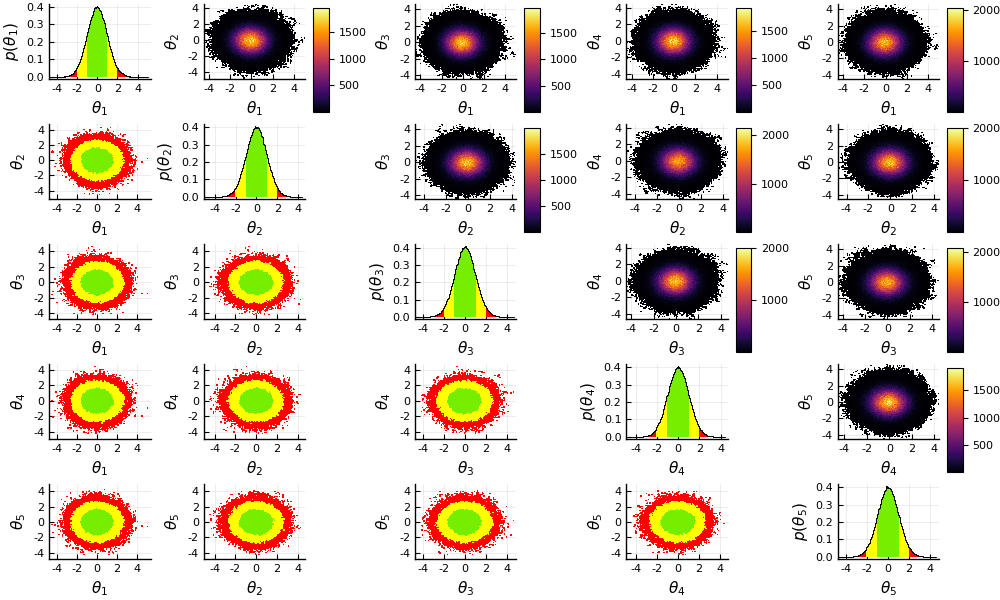

In [56]:
plot(samples)

In [57]:
size(samples.v)

(1000000,)

In [60]:
hmi_data = BAT.HMIData(unshaped.(samples))

@time BAT.hm_integrate!(hmi_data, settings = HMI_Manual_Settings)

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	30
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████

371.146954 seconds (4.70 G allocations: 302.006 GiB, 22.60% gc time)


┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


Parameters: 30	Total Samples: 999999
Data Set 1: 252 Volumes
Data Set 2: 246 Volumes

Integral Estimate (cov. weighted result):
	 1.1119e-39  +-  1.78419e-41


In [29]:
PATH = pwd()*"/output.jld"
nchains = 5
nsamples = 2*10^5
max_time = 100
max_nsteps = 10 * nsamples
prior_bounds = [min_v, max_v]

function run_integrations(dim_range::StepRange{Int64,Int64}, n_repeat::Int64; 
    nchains = nchains,
    nsamples = nsamples,
    max_time = max_time,
    max_nsteps = max_nsteps,
    log_likelihood = log_likelihood,
    prior_bounds = prior_bounds,
    HMI_Manual_Settings = HMI_Manual_Settings)
	
    # information that we want to track 
	integrals_ahmi_array = Vector{Float64}()
	integrals_true_array = Vector{Float64}()
	dim_array = Vector{Int64}()
	uns_ahmi_array = Vector{Float64}()
	mcmc_time_array = Vector{Float64}()
	ahmi_time_array = Vector{Float64}()
	n_samples_array = Vector{Tuple{Int64,Int64}}()
	tot_volumes_accepted1_array = Vector{Int64}()
    tot_volumes_rejected1_array = Vector{Int64}()
    tot_volumes_accepted2_array = Vector{Int64}()
    tot_volumes_rejected2_array = Vector{Int64}()
    
    int_estimates_1_array = Vector{Any}()
    int_estimates_2_array = Vector{Any}()
    
	for dim_run in dim_range
		
		@show dim_run

		prior = NamedTupleDist(a = [[prior_bounds[1] .. prior_bounds[2] for i in 1:dim_run]...],)
		posterior = PosteriorDensity(log_likelihood, prior)
		lgV_run = dim_run*log(prior_bounds[2]-prior_bounds[1])
        
        ####### Problem-specific 
		integral_true_run = 0.0 #dim_run*log(cdf(Cauchy(5,1), prior_bounds[2]) - cdf(Cauchy(5,1), prior_bounds[1])) # Problem-specific 
        ####### Problem-specific 

		for n_run in 1:n_repeat

			@show dim_run, n_run

			mcmc_ex_time = @CPUelapsed begin (samples, chains) = bat_sample(
                    posterior, (nsamples, nchains), algorithm,
                    max_nsteps = max_nsteps,
                    max_time = max_time,
                    tuning = tuning,
                    init = init,
                    burnin = burnin,
                    convergence = convergence,
                    strict = false,
                    filter = true
                );
            end

			hmi_data = BAT.HMIData(unshaped.(samples))
			ahmi_ex_time = @CPUelapsed BAT.hm_integrate!(hmi_data, settings = HMI_Manual_Settings)

			ahmi_integral_run =[hmi_data.integralestimates["cov. weighted result"].final.estimate, hmi_data.integralestimates["cov. weighted result"].final.uncertainty]
			log_smpl_int = log.(ahmi_integral_run) .+ lgV_run
            
            push!(int_estimates_1_array, [hmi_data.integrals1.integrals])
            push!(int_estimates_2_array, [hmi_data.integrals2.integrals])
            
            push!(dim_array, dim_run)
			push!(n_samples_array, size(flatview(unshaped.(samples.v))))
            
			push!(tot_volumes_accepted1_array, length(hmi_data.volumelist1))
			push!(tot_volumes_accepted2_array, length(hmi_data.volumelist2))
			push!(tot_volumes_rejected1_array, length(hmi_data.rejectedrects1))
			push!(tot_volumes_rejected2_array, length(hmi_data.rejectedrects2))
			
			push!(mcmc_time_array, mcmc_ex_time)
			push!(ahmi_time_array, ahmi_ex_time)

			push!(integrals_ahmi_array, log_smpl_int[1])
			push!(integrals_true_array, integral_true_run)
			push!(uns_ahmi_array, log_smpl_int[2])

		end
		
		save_data(deepcopy(n_samples_array), 
            deepcopy(integrals_true_array), 
            deepcopy(integrals_ahmi_array), 
            deepcopy(uns_ahmi_array), 
            deepcopy(mcmc_time_array), 
            deepcopy(ahmi_time_array), 
            deepcopy(dim_array), 
            deepcopy(dim_run), 
            deepcopy(tot_volumes_accepted1_array), 
            deepcopy(tot_volumes_accepted2_array), 
            deepcopy(tot_volumes_rejected1_array), 
            deepcopy(tot_volumes_rejected2_array),
            deepcopy(int_estimates_1_array), 
            deepcopy(int_estimates_2_array))
		
    end
end

run_integrations (generic function with 1 method)

In [30]:
function save_data(n_samples_array::Vector{Tuple{Int64,Int64}}, 
        integrals_true_array::Vector{Float64}, 
        integrals_ahmi_array::Vector{Float64}, 
        uns_ahmi_array::Vector{Float64}, 
        mcmc_time_array::Vector{Float64}, 
        ahmi_time_array::Vector{Float64}, 
        dim_array::Vector{Int64}, 
        dim_run::Int64, 
        tot_volumes_accepted1_array::Vector{Int64}, 
        tot_volumes_accepted2_array::Vector{Int64}, 
        tot_volumes_rejected1_array::Vector{Int64}, 
        tot_volumes_rejected2_array::Vector{Int64},
        int_estimates_1_array::Vector{Any},
        int_estimates_2_array::Vector{Any};
        PATH=PATH)
    
	x_dms = Int64(length(integrals_ahmi_array)/length(unique(dim_array)))
    y_dms = Int64(dim_array[end]-dim_array[1]+1)
    
    n_samples_array = reshape(n_samples_array, x_dms, y_dms)
	integrals_true_array = reshape(integrals_true_array, x_dms, y_dms)
	integrals_ahmi_array = reshape(integrals_ahmi_array, x_dms, y_dms)
	
	tot_volumes_accepted1_array = reshape(tot_volumes_accepted1_array, x_dms, y_dms)
	tot_volumes_accepted2_array = reshape(tot_volumes_accepted2_array, x_dms, y_dms)
	tot_volumes_rejected1_array = reshape(tot_volumes_rejected1_array, x_dms, y_dms)
	tot_volumes_rejected2_array = reshape(tot_volumes_rejected2_array, x_dms, y_dms)
    
    int_estimates_1_array = reshape(int_estimates_1_array, x_dms, y_dms)
	int_estimates_2_array = reshape(int_estimates_2_array, x_dms, y_dms)
		
	uns_ahmi_array = reshape(uns_ahmi_array, x_dms, y_dms)
	mcmc_time_array = reshape(mcmc_time_array, x_dms, y_dms)
	ahmi_time_array = reshape(ahmi_time_array, x_dms, y_dms)
    dim_array = reshape(dim_array, x_dms, y_dms)
		
	integrals_ahmi_array = convert(Array{Float64,2}, integrals_ahmi_array)
	uns_ahmi_array = convert(Array{Float64,2}, uns_ahmi_array);
		
	isfile(PATH) && rm(PATH)
	@show "saving"
	save(PATH, 
		"sample_size", n_samples_array, 
		"integrals_ahmi_array", integrals_ahmi_array, 
		"integrals_true_array", integrals_true_array,  
		"uns_ahmi_array", uns_ahmi_array,  
		"dim_array", dim_array, 
		"mcmc_time_array", mcmc_time_array,
		"ahmi_time_array", ahmi_time_array,
		"tot_volumes_accepted1_array", tot_volumes_accepted1_array,
		"tot_volumes_accepted2_array", tot_volumes_accepted2_array, 
		"tot_volumes_rejected1_array", tot_volumes_rejected1_array, 
		"tot_volumes_rejected2_array", tot_volumes_rejected2_array,
        "int_estimates_1_array", int_estimates_1_array, 
		"int_estimates_2_array", int_estimates_2_array,
	)
end


save_data (generic function with 2 methods)

In [31]:
dim_range = range(3, step=1, stop=10)

@CPUtime run_integrations(dim_range, 10)

dim_run = 3
(dim_run, n_run) = (3, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Paramet

(dim_run, n_run) = (3, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (3, 3)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (3, 4)


┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: In

(dim_run, n_run) = (3, 5)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (3, 6)


┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warni

(dim_run, n_run) = (3, 7)


┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warni

(dim_run, n_run) = (3, 8)


┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 34 Hyp

(dim_run, n_run) = (3, 9)


┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warni

(dim_run, n_run) = (3, 10)


┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warni

"saving" = "saving"
dim_run = 

┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


4
(dim_run, n_run) = (4, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Paramet

(dim_run, n_run) = (4, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 3)


┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 34 Hyp

(dim_run, n_run) = (4, 4)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 5)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 6)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 7)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (4, 8)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 9)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (4, 10)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

"saving" = "saving"
dim_run = 5
(dim_run, n_run) = (5, 1)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 3)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 4)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 5)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (5, 6)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (5, 7)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 8)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (5, 9)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (5, 10)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

"saving" = "saving"
dim_run = 6
(dim_run, n_run) = (6, 1)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 3)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 4)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 5)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (6, 6)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 7)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (6, 8)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (6, 9)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/v

(dim_run, n_run) = (6, 10)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

"saving" = "saving"
dim_run = 7
(dim_run, n_run) = (7, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Paramete

(dim_run, n_run) = (7, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (7, 3)


┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (7, 4)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (7, 5)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (7, 6)


┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (7, 7)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (7, 8)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (7, 9)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (7, 10)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

"saving" = "saving"
dim_run = 

┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


8
(dim_run, n_run) = (8, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	5000 / 4999	Paramete

(dim_run, n_run) = (8, 2)


┌ Info: Updating 38 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 38 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 3)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 32 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 4)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (8, 5)


┌ Info: Updating 36 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 36 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 6)


┌ Info: Create 37 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 37 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 37 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (8, 7)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 8)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 9)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (8, 10)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

"saving" = "saving"
dim_run = 

┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


9
(dim_run, n_run) = (9, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 9 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 3 cycle(s).
└ @ BAT /home/iwsa

(dim_run, n_run) = (9, 2)


┌ Info: Create 38 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 38 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 38 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (9, 3)


┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (9, 4)


┌ Info: Create 41 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 41 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 41 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (9, 5)


┌ Info: Create 41 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 41 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 41 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (9, 6)


┌ Info: Updating 39 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 39 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (9, 7)


┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (9, 8)


┌ Info: Create 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (9, 9)


┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (9, 10)


┌ Info: Updating 39 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 39 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

"saving" = "saving"
dim_run = 

┌ Info: Create 36 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 36 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 36 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


10
(dim_run, n_run) = (10, 1)


┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 10 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 10 tuned, 10 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 10 chains successful after 3 cycle(s).
└ @ BAT /home/iwsa

(dim_run, n_run) = (10, 2)


┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 32 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 32 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (10, 3)


┌ Info: Create 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (10, 4)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (10, 5)


┌ Info: Create 40 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 40 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 40 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (10, 6)


┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (10, 7)


┌ Info: Create 43 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 43 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 43 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

(dim_run, n_run) = (10, 8)


┌ Info: Updating 36 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 36 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (10, 9)


┌ Info: Updating 38 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 36 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vh

(dim_run, n_run) = (10, 10)


┌ Info: Create 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 35 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 35 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhaf

"saving" = "saving"
elapsed CPU time: 

┌ Info: Create 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 34 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 34 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:385
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:59


1156.474595 seconds


In [33]:
saved = load(PATH);

In [34]:
integrals_ahmi = saved["integrals_ahmi_array"]
integrals_true = saved["integrals_true_array"]
uns_ahmi = saved["uns_ahmi_array"]
dim_array = saved["dim_array"]
sample_size = saved["sample_size"]
ahmi_time_array = saved["ahmi_time_array"]
mcmc_time_array = saved["mcmc_time_array"]

tot_volumes_accepted1_array = saved["tot_volumes_accepted1_array"]
tot_volumes_accepted2_array = saved["tot_volumes_accepted2_array"]

int_estimates_1_array = saved["int_estimates_1_array"]
int_estimates_2_array = saved["int_estimates_2_array"]

tot_volumes_rejected1_array = saved["tot_volumes_rejected1_array"]
tot_volumes_rejected2_array = saved["tot_volumes_rejected2_array"];

dim_range = sort(unique(dim_array));

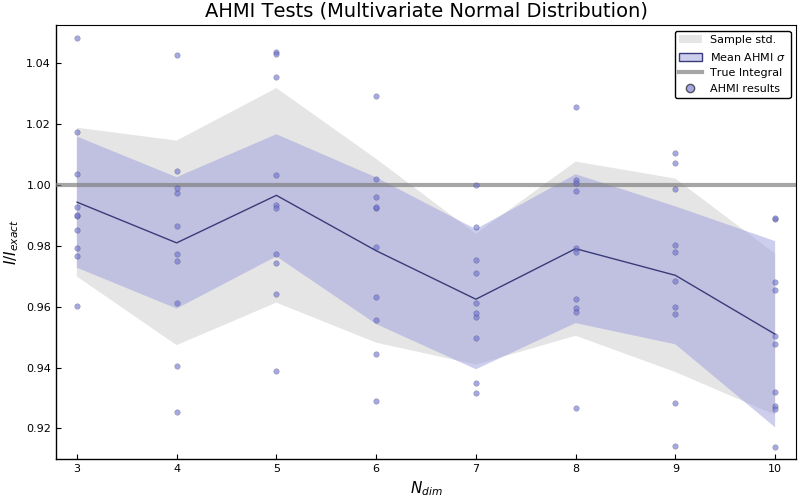

In [35]:
integrals = exp.(integrals_ahmi .- integrals_true)
unsertanity_ahmi = exp.(uns_ahmi .- integrals_true);
unsertanity_scatter = std(integrals, dims=1)'

mean_integrals = mean(integrals, dims=1)'
unsertanity_ahmi = mean(unsertanity_ahmi, dims=1)';

plot(dim_range, mean_integrals, ribbon=(unsertanity_scatter, unsertanity_scatter),
    linecolor=line_colors[1], fillcolor=:darkgray, fillalpha=0.3, lw=0, label="Sample std.")

plot!(dim_range, mean_integrals, ribbon=(unsertanity_ahmi, unsertanity_ahmi),
    linecolor=line_colors[1], fillcolor=line_colors[4], fillalpha=0.5, label="Mean AHMI \$\\sigma\$")

hline!([1], 
    linecolor=:gray, 
    lw=3, 
    linealpha=0.7, label="True Integral")

scatter!([dim_array...], [integrals...], #yerror = unsertanity, linealpha=0.1,
    lw=0.0, markeralpha=0.6,
    markercolor=line_colors[3], 
    markerstrokewidth=0.1, label="AHMI results")

plot!(box=true, 
    grid=false, 
    size=(800, 500),
    xticks = dim_range,
#     xlim=(0, 22),
    title = "AHMI Tests (Multivariate Normal Distribution)",
    xlabel = L"N_{dim}", 
    ylabel = L"I/I_{exact}", 
)

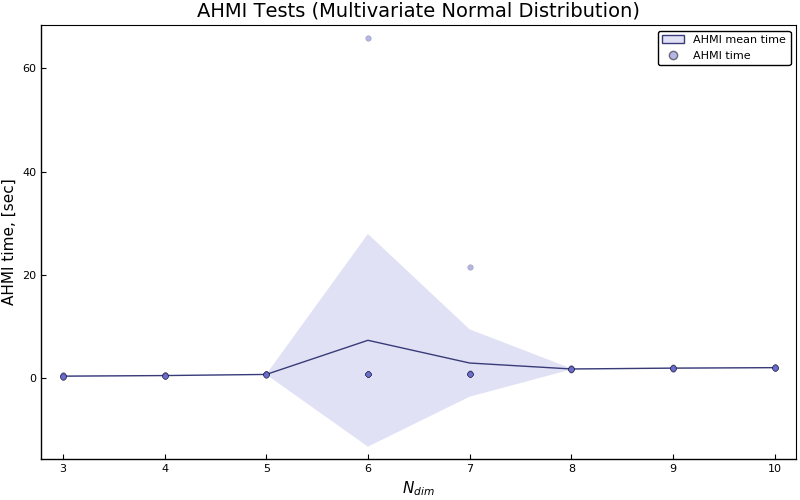

In [36]:
mean_time = mean(ahmi_time_array, dims=1)'
std_time = std(ahmi_time_array, dims=1)'


plot(dim_range, mean_time, ribbon=(std_time, std_time),
    linecolor=line_colors[1], fillcolor=line_colors[4], fillalpha=0.3, label="AHMI mean time")

scatter!([dim_array...], [ahmi_time_array...],
    lw=0.0, markeralpha=0.5,
    markercolor=line_colors[3], 
    markerstrokewidth=0.1, label="AHMI time")

plot!(box=true, 
    grid=false, 
    size=(800, 500),
    xticks = dim_range,
#     xlim=(0, 22),
    title = "AHMI Tests (Multivariate Normal Distribution)",
    xlabel = L"N_{dim}", 
    ylabel = "AHMI time, [sec]", 
)

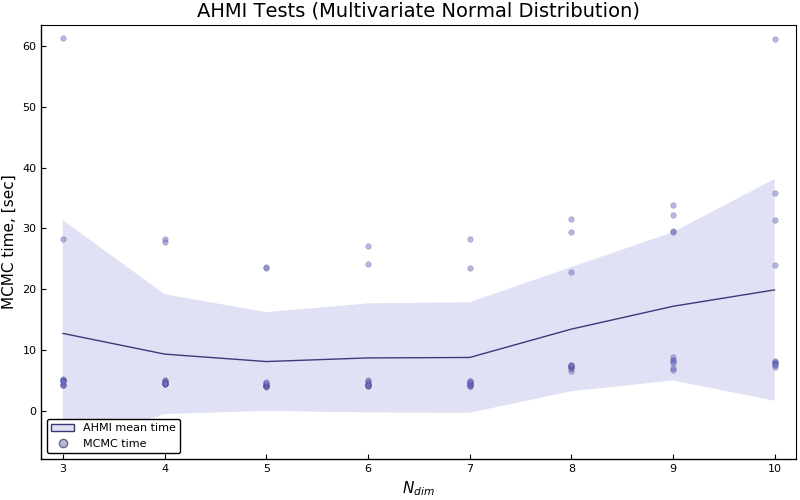

In [37]:
mcmc_mean_time = mean(mcmc_time_array, dims=1)'
mcmc_std_time = std(mcmc_time_array, dims=1)'


plot(dim_range, mcmc_mean_time, ribbon=(mcmc_std_time, mcmc_std_time),
    linecolor=line_colors[1], fillcolor=line_colors[4], fillalpha=0.3,  label="AHMI mean time")

scatter!([dim_array...], [mcmc_time_array...],
    lw=0.0, markeralpha=0.5,
    markercolor=line_colors[3], 
    markerstrokewidth=0.1, label="MCMC time")

plot!(box=true, 
    grid=false, 
    size=(800, 500),
    xticks = dim_range,
#     xlim=(0, 22),
    title = "AHMI Tests (Multivariate Normal Distribution)",
    xlabel = L"N_{dim}", 
    ylabel = "MCMC time, [sec]", 
)

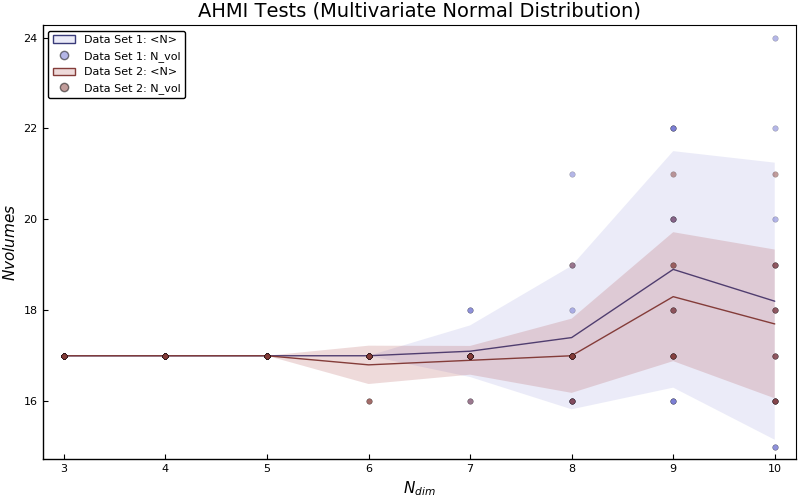

In [38]:
tot_volumes_accepted1_array_mean = mean(tot_volumes_accepted1_array, dims=1)'
tot_volumes_accepted2_array_mean = mean(tot_volumes_accepted2_array, dims=1)'

tot_volumes_accepted1_array_std = std(tot_volumes_accepted1_array, dims=1)'
tot_volumes_accepted2_array_std = std(tot_volumes_accepted2_array, dims=1)'


plot(dim_range, tot_volumes_accepted1_array_mean, ribbon=(tot_volumes_accepted1_array_std, tot_volumes_accepted1_array_std),
    linecolor=line_colors[1], fillcolor=line_colors[4], fillalpha=0.2,  label="Data Set 1: <N>")

scatter!([dim_array...], [tot_volumes_accepted1_array...],
    lw=0.0, markeralpha=0.5,
    markercolor=line_colors[3], 
    markerstrokewidth=0.1, label="Data Set 1: N_vol")

plot!(dim_range, tot_volumes_accepted2_array_mean, ribbon=(tot_volumes_accepted2_array_std, tot_volumes_accepted2_array_std),
    linecolor=line_colors[13], fillcolor=line_colors[14], fillalpha=0.2, label="Data Set 2: <N>")

scatter!([dim_array...], [tot_volumes_accepted2_array...],
    lw=0.0, markeralpha=0.5,
    markercolor=line_colors[13], 
    markerstrokewidth=0.1,  label="Data Set 2: N_vol")

plot!(box=true, 
    grid=false, 
    size=(800, 500),
    xticks = dim_range,
#     xlim=(0, 22),
    title = "AHMI Tests (Multivariate Normal Distribution)",
    xlabel = L"N_{dim}", 
    ylabel = L"N volumes", 
)